In [1]:
import numpy as np
import torch as tr
import torch.nn as nn
from torch import distributions
from torch.nn.parameter import Parameter
import phi4_mg as m
import phi4 as p
import integrators as i
import update as u

import time
import matplotlib.pyplot as plt
from tqdm import tqdm

import argparse
import sys
    
import time
from stacked_model import *



In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
os.environ["PATH"] = "/sciclone/home/yacahuanamedra/texlive/bin/x86_64-linux:" + os.environ["PATH"]

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amsfonts}')
import pickle


from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

mpl.rc('font', **font)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

mpl.rc('font', **font)

## Discrete action

\begin{equation}
S[\phi] = \sum_{x} \left[ 
    \frac{1}{2} \tilde{m} \, \phi(x)^2 
    + \frac{\lambda}{24} \, \phi(x)^4 
    - \sum_{\mu=1}^{N_d} \phi(x) \, \phi(x + \hat{\mu}) 
\right]
\end{equation}

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Dec  10 9:38:24 2019

@author: Kostas Orginos
I have just modified it to work on arbitrary dimensions and do checks

"""

import numpy as np
import torch as tr

class phi4():
    def action(self,phi):
        #A = 0.5*self.mtil*tr.einsum('bxy,bxy->b',phi,phi) + (self.lam/24.0)*tr.einsum('bxy,bxy->b',phi**2,phi**2)
        #for mu in range(1,self.Nd+1):
        #    A = A - tr.einsum('bxy,bxy->b',phi,tr.roll(phi,shifts=-1,dims=mu))

        phi2 = phi*phi
        #A = tr.sum((0.5*self.mtil + (self.lam/24.0)*phi2)*phi2,dim=(1,2))
        #for mu in range(1,self.Nd+1):
        #    A = A - tr.sum(phi*tr.roll(phi,shifts=-1,dims=mu),dim=(1,2))

            
        A = tr.sum((0.5*self.mtil + (self.lam/24.0)*phi2)*phi2, dim=tuple(range(1, self.Nd+1)))
        for mu in range(1, self.Nd+1):
            A = A - tr.sum(phi * tr.roll(phi, shifts=-1, dims=mu), dim=tuple(range(1, self.Nd+1)))
        return A
    
    def force(self,phi):
        F = -self.mtil*phi - self.lam*phi**3/6.0
        for mu in range(1,self.Nd+1):
            F +=  tr.roll(phi,shifts= 1,dims=mu)+tr.roll(phi,shifts=-1,dims=mu)
        return F


    def refreshP(self):
        shape = [self.Bs] + list(self.V)
        P = tr.normal(0.0,1.0,shape,dtype=self.dtype,device=self.device)
        return P

    def evolveQ(self,dt,P,Q):
        return Q + dt*P
    
    def kinetic(self,P):
        spatial_dims = ''.join(chr(ord('a') + i) for i in range(self.Nd))#abcd for d=4
        einsum_str = f"z{spatial_dims},z{spatial_dims}->z"
        return tr.einsum(einsum_str,P,P)/2.0

    def hotStart(self):
        shape = [self.Bs] + list(self.V)
        sigma = tr.normal(0.0, 1.0, shape, dtype=self.dtype, device=self.device)
        return sigma
    
    def __init__(self,V,l,m,batch_size=1,device="cpu",dtype=tr.float32): 
            self.V = tuple(V) # lattice size
            self.Vol = np.prod(V)
            self.Nd = len(V)
            self.lam = l # the coupling
            self.mass  = m
            self.mtil = m + 2*self.Nd
            self.Bs=batch_size
            self.device=device
            self.dtype=dtype



def main():
    import time
    import matplotlib.pyplot as plt
    
    device = "cuda" if tr.cuda.is_available() else "cpu"
    print(f"Using {device} device")
    L=32
    batch_size=1
    lam =0.1
    mass= 0.1
    o = phi4([L],lam,mass,batch_size=batch_size, device=device, dtype=tr.float32)

    phi=o.hotStart()
    #plt.imshow(phi[0,:,:,1,2].detach().cpu().numpy(), cmap='hot', interpolation='nearest')
    #plt.show()
    print(f"phi shape {phi.shape} dtype {phi.dtype} device {phi.device}")
    tic=time.perf_counter()
    Niter=10000
    for k in range(Niter):
        o.action(phi)
    toc=time.perf_counter()
    print(f"action time {(toc - tic)*1.0e6/Niter:0.4f} micro-seconds")

    tic=time.perf_counter()
    for k in range(Niter):
        o.force(phi)
    toc=time.perf_counter()
    print(f"force time {(toc - tic)*1.0e6/Niter:0.4f} micro-seconds")    

    P = o.refreshP()

    tic=time.perf_counter()
    for k in range(Niter):
        o.kinetic(phi)
    toc=time.perf_counter()
    print(f"kinetic time {(toc - tic)*1.0e6/Niter:0.4f} micro-seconds")    

if __name__ == "__main__":
   main()

Using cuda device
phi shape torch.Size([1, 32]) dtype torch.float32 device cuda:0
action time 79.4677 micro-seconds
force time 74.4008 micro-seconds
kinetic time 35.9149 micro-seconds


In [ ]:
phase=tr.tensor(np.exp(1j*np.indices(tuple(lat))[0]*2*np.pi/lat[0]))
for k in range(Nmeas):
    ttE = sg.action(phi)/Vol
    E.extend(ttE)
    av_sigma = tr.mean(phi.view(sg.Bs,Vol),axis=1)
    av_phi.extend(av_sigma)
    chi_m = av_sigma*av_sigma*Vol
    p1_av_sig = tr.mean(phi.view(sg.Bs,Vol)*phase.view(1,Vol),axis=1)
    C2p = tr.real(tr.conj(p1_av_sig)*p1_av_sig)*Vol
    if(k%10==0):
        print("k= ",k,"(av_phi,chi_m, c2p, E) ", av_sigma.mean().numpy(),chi_m.mean().numpy(),C2p.mean().numpy(),ttE.mean().numpy())
    lC2p.extend(C2p)
    lchi_m.extend(chi_m)
    phi = hmc.evolve(phi,Nskip)

Phase in the code $\delta_n=e^{\frac{2i\pi}{L}n}$ with $p_n=\frac{2\pi}{L}n$

\begin{align}
\text{Field average:} \quad
\langle \phi \rangle &= \frac{1}{V} \sum_x \phi(x) \\[8pt]
\text{Magnetic susceptibility:} \quad
\chi_m &= V \cdot \langle \phi \rangle^2 \\[8pt]
\text{Two-point correlator at momentum $p$}: \quad
C_2(p) &= V \cdot \left| \frac{1}{V} \sum_x \phi(x) \, e^{i p_n x} \right|^2 \\[8pt]
\text{Energy density:} \quad
E &= \frac{S[\phi]}{V}
\end{align}

In [7]:
#!/usr/local/bin/python3
import time
import numpy as np
import torch as tr
import phi4 as s
import integrators as i
import update as u

import matplotlib.pyplot as plt

device = "cuda" if tr.cuda.is_available() else "cpu"
if(device=="cpu"):
    device = "mps" if tr.backends.mps.is_available() else "cpu"
# OK I will always use CPU for now
device = "cpu"
device = tr.device(device)
print(f"Using {device} device")

    
def jackknife(d):
    # d is the list containing data
    # NOTE: it works with python lists not numpy arrays
    #
    N=len(d) -1 
    ss = sum(d)
    r=[]
    for n in range(len(d)):
        r.append((ss-d[n])/N)

    return r

def average(d):
    m = np.mean(d)
    e = np.std(d)/np.sqrt(len(d)-1)
    return m,e

def correlation_length(L,ChiM,C2p):
     return 1/(2*np.sin(np.pi/L))*np.sqrt(ChiM/C2p -1)

L=48
lat = [L,L]
# This set of params is very very close to critical.
lam = 0.1
mas = 0.1
#
Nwarm = 100
Nmeas = 1000
Nskip = 10
batch_size = 32

Vol = np.prod(lat)


sg = s.phi4(lat,lam,mas,batch_size=batch_size,device=device)

phi = sg.hotStart()
mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
 
print(phi.shape,Vol,tr.mean(phi),tr.std(phi))


hmc = u.hmc(T=sg,I=mn2,verbose=False)

tic=time.perf_counter()
phi = hmc.evolve(phi,Nwarm)
toc=time.perf_counter()
print(f"time {(toc - tic)*1.0e6/Nwarm:0.4f} micro-seconds per HMC trajecrory")

lC2p = []
lchi_m = []
E = []
av_phi = []
phase=tr.tensor(np.exp(1j*np.indices(tuple(lat))[0]*2*np.pi/lat[0]))
for k in range(Nmeas):
    ttE = sg.action(phi)/Vol
    E.extend(ttE)
    av_sigma = tr.mean(phi.view(sg.Bs,Vol),axis=1)
    av_phi.extend(av_sigma)
    chi_m = av_sigma*av_sigma*Vol
    p1_av_sig = tr.mean(phi.view(sg.Bs,Vol)*phase.view(1,Vol),axis=1)
    C2p = tr.real(tr.conj(p1_av_sig)*p1_av_sig)*Vol
    if(k%10==0):
        print("k= ",k,"(av_phi,chi_m, c2p, E) ", av_sigma.mean().numpy(),chi_m.mean().numpy(),C2p.mean().numpy(),ttE.mean().numpy())
    lC2p.extend(C2p)
    lchi_m.extend(chi_m)
    phi = hmc.evolve(phi,Nskip)


m_phi, e_phi = average(av_phi)
print("m_phi: ",m_phi,e_phi)

m_chi_m, e_chi_m = average(np.array(lchi_m) - (m_phi**2)*Vol)
m_C2p, e_C2p     = average(lC2p)
print(r"$\chi_m$: ",m_chi_m,'+/-', e_chi_m)
print("C2p  : ",m_C2p,'+/-', e_C2p)
avE,eE = average(E)
print("E = ", avE ,'+/-',eE)

xi = correlation_length(lat[0],m_chi_m, m_C2p)
print("The correlation length is: ",xi)
jphi   = jackknife(av_phi)
jchi_m = jackknife(lchi_m)- np.array(jphi)**2 * Vol
jC2p   = np.array(jackknife(lC2p)) 


j_xi = correlation_length(lat[0],jchi_m,jC2p)

m_xi,e_xi = average(j_xi)


print("The correlation length from jackknife is is: ",m_xi," +/- ", e_xi)


#save the last field configuration
#tr.save(phi,'phi4_'+str(lat[0])+"_"+str(lat[1])+"_m"+str(mas)+"_l"+str(lam)+".pt")


Using cpu device
torch.Size([32, 48, 48]) 2304 tensor(-0.0049) tensor(1.0036)


time 5736.4379 micro-seconds per HMC trajecrory
k=  0 (av_phi,chi_m, c2p, E)  0.00049713417 5.7776017 7.9528569467337284 0.49651188
k=  10 (av_phi,chi_m, c2p, E)  0.022580203 7.0731306 5.382895472194157 0.49600172
k=  20 (av_phi,chi_m, c2p, E)  -0.005460732 5.6781397 7.867554941761359 0.499004
k=  30 (av_phi,chi_m, c2p, E)  0.0067221345 6.4955606 6.573513775371766 0.49532834
k=  40 (av_phi,chi_m, c2p, E)  -0.00023398409 5.886916 6.590217195991572 0.49428642
k=  50 (av_phi,chi_m, c2p, E)  -0.009005072 11.3806 8.09433969751367 0.49554372
k=  60 (av_phi,chi_m, c2p, E)  0.011402225 7.109985 7.633204376315192 0.4943401
k=  70 (av_phi,chi_m, c2p, E)  0.0023042923 6.4579954 7.079275345190251 0.4974811
k=  80 (av_phi,chi_m, c2p, E)  0.0017890276 9.014593 7.848416078709475 0.5028132
k=  90 (av_phi,chi_m, c2p, E)  -0.013709304 7.394551 9.487333032241683 0.49691886
k=  100 (av_phi,chi_m, c2p, E)  -0.011230944 7.212167 4.567471727577749 0.50060594
k=  110 (av_phi,chi_m, c2p, E)  0.016869858 8.6562

### Relations of meassurements

In [28]:
phi.view(sg.Bs,Vol).shape

torch.Size([32, 2304])

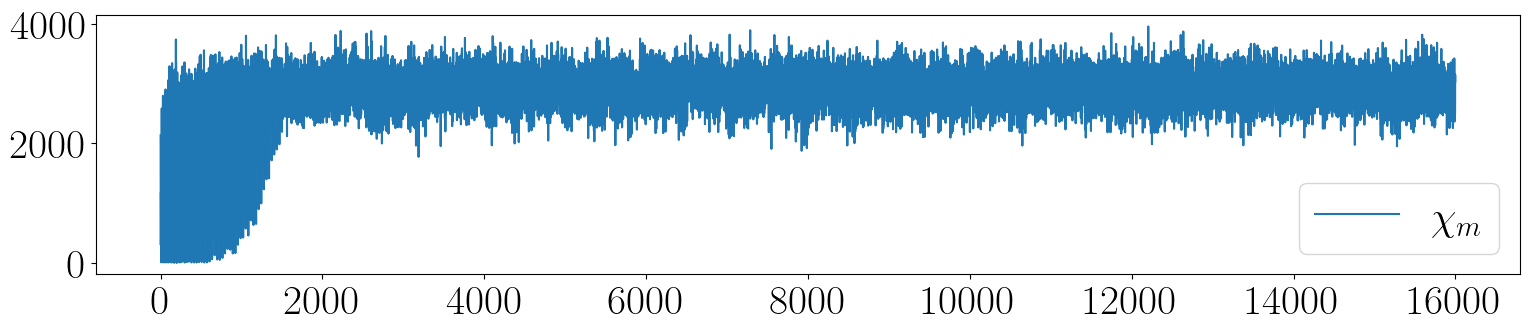

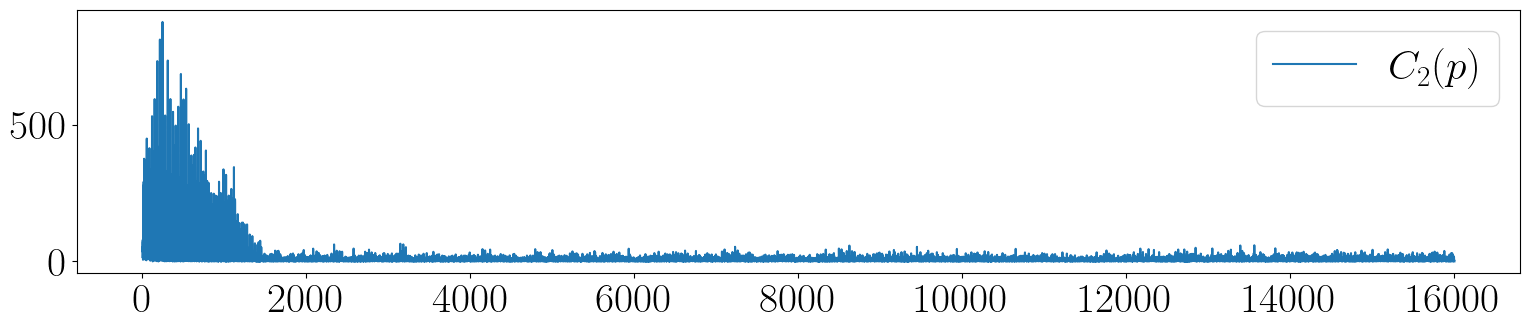

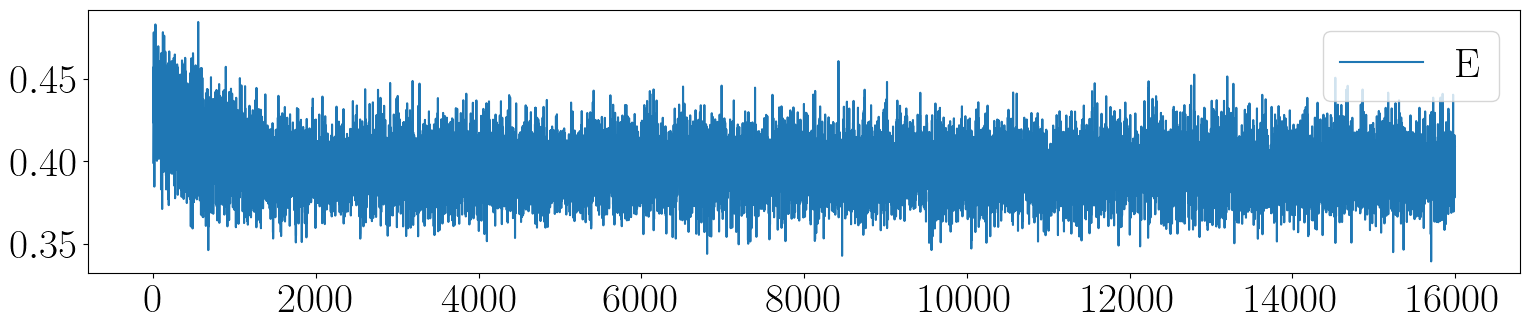

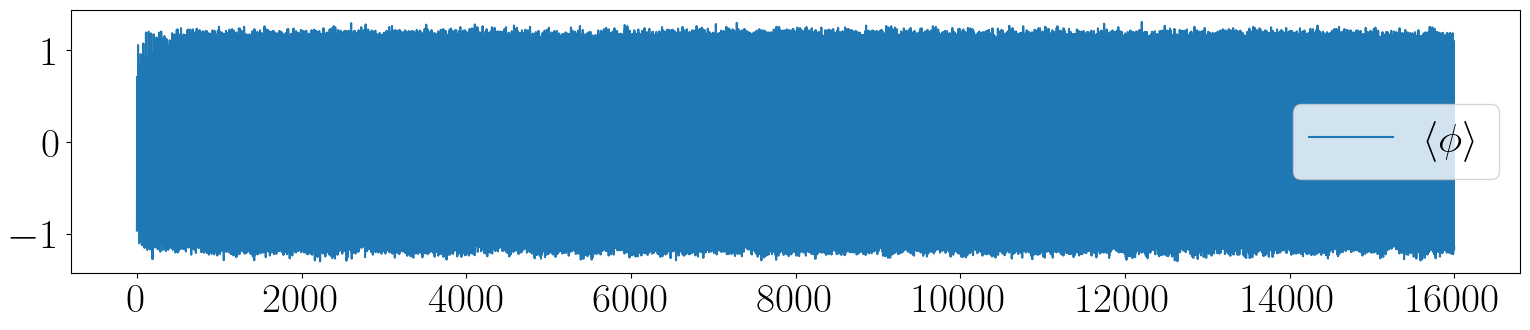

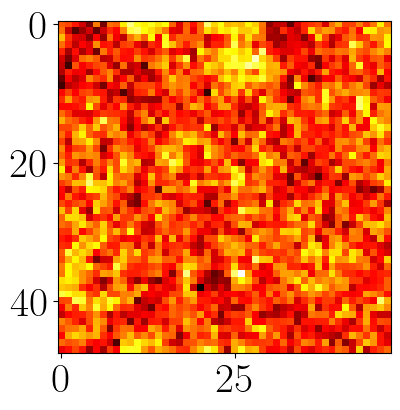

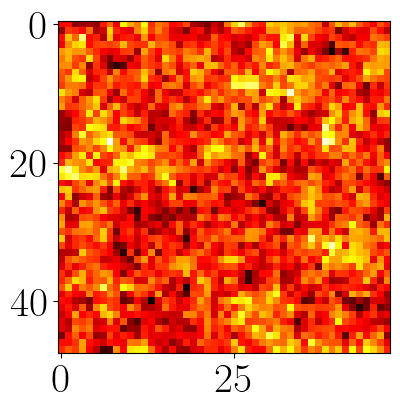

In [32]:

#size of the plot
plt.figure(figsize=(16, 4))
plt.plot(range(len(lchi_m)),lchi_m, label=r'$\chi_m$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.plot(range(len(lC2p)),lC2p, label=r'$C_2(p)$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.plot(range(len(E)),E, label=r'E')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.plot(range(len(av_phi)),av_phi, label=r'$\langle\phi\rangle$')
plt.legend()
plt.show()


plt.imshow(phi[0,:,:], cmap='hot', interpolation='nearest')
plt.show()
plt.imshow(phi[1,:,:], cmap='hot', interpolation='nearest')